#### EMACS LISP STUFF PLEASE IGNORE
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*"))

In [1]:
%pylab inline
import os,sys
from importlib import reload
from collections import defaultdict
from copy import deepcopy
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
from matplotlib.gridspec import GridSpec
from scipy.signal import stft
from builtins import sum as bsum
import matplotlib.transforms as mtransforms

Populating the interactive namespace from numpy and matplotlib


In [28]:
from collections import namedtuple

In [2]:
plt.rcParams["figure.figsize"] = (8,3)

In [3]:
# Don't reload this, otherwise it will create a new units registry object
# and will then complain about combining different registries.
import units; reload(units); UNITS = units.UNITS; 

In [4]:
flush = lambda *args, **kwargs: [sys.stdout.flush(), print(*args, **kwargs)]

In [193]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils); from utils import dict_update, dict_update_from_field
FisherPlumes = fp.FisherPlumes
crick.logger.setLevel(logging.DEBUG)
fp.logger.setLevel(logging.INFO)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_first_slow_w1                          : y0 - y9 (16 datasets)


INFO:crick:crimgrid_first_slow_w2                          : y0 - y9 (16 datasets)


INFO:crick:crimgrid_first_slow_w3                          : y0 - y9 (16 datasets)


INFO:crick:crimgrid_first_slow_w4                          : y0 - y9 (16 datasets)


INFO:crick:ff_int_sym_slow_high_tres_wide_n12T             : Y0.450 - Y0.550 (11 datasets)


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


In [194]:
Info = namedtuple('Info','name,load,color')
infos = {"12dT": Info(name="12 src, dish", load="n12dishT",  color = cm.cool_r(0.8)),
         "12T":  Info(name="12 src",       load="n12T",      color = cm.cool_r(0.8)),
         "12Ts": Info(name="12 src, slow", load="n12Tslow",  color = cm.cool_r(0.8)),
         "16T":  Info(name="16 src",       load="n16T",      color = cm.cool_r(0.8)),
         "16Ts": Info(name="16 src, slow", load="n16Tslow",  color = cm.cool_r(0.8)),
         "bw":   Info(name="Main dataset", load="boulder16", color = cm.cool_r(0.0)),
         "su":   Info(name="Surrogate (all equally informative, data spectrum)", load="surr_all_equal", color = "C1"),
         "suw":  Info(name="Surrogate (high>low, white spectrum)",               load="surr_high",      color = "C0"),
         "sup":  Info(name="Surrogate (high>low, data spectrum)",                load="surr_high",      color = "pink"),
         "w1":Info(name="w1", load="crimgrid_first_slow_w1", color="C2"),
         "w2":Info(name="w2", load="crimgrid_first_slow_w2", color="C3"),
         "w3":Info(name="w3", load="crimgrid_first_slow_w3", color="C4"),
         "w4":Info(name="w4", load="crimgrid_first_slow_w4", color="C5"),
}


In [ ]:
n_bootstraps = 50
pairs_mode = "unsigned"

force_reload = True

to_use = ["w1", "w2", "w3", "w4", "su"] 

useQ = lambda ds: ds in to_use

if 'FF' not in locals(): FF = {}

if useQ("w1"):
    FF["w1"] = FisherPlumes(infos["w1"].load,
                              freq_max = 100 * UNITS.hertz,
                              which_coords = [(0.5, 0.5),
                                              #(0.9,0.5),
                                              #(0.7,0.5),
                                              #(0.6,0.5)
                              ]*UNITS.m,
                              py_mode = "relative",
                            pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0,
                            max_time = 50 * UNITS.sec,                            
    ) if (force_reload or ('w1' not in FF)) else FisherPlumes(FF["w1"])

if useQ("w4"):
    FF["w4"] = FisherPlumes(infos["w4"].load,
                              freq_max = 100 * UNITS.hertz,
                              which_coords = [(0.5, 0.5),
                                              #(0.9,0.5),
                                              #(0.7,0.5),
                                              #(0.6,0.5)
                              ]*UNITS.m,
                              py_mode = "relative",
                            pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0,
                            max_time = 50 * UNITS.sec,
    ) if (force_reload or ('w4' not in FF)) else FisherPlumes(FF["w4"])

if useQ("w2"):
    FF["w2"] = FisherPlumes(infos["w2"].load,
                              freq_max = 100 * UNITS.hertz,
                              which_coords = [(0.5, 0.5),
                                              #(0.9,0.5),
                                              #(0.7,0.5),
                                              #(0.6,0.5)
                              ]*UNITS.m,
                              py_mode = "relative",
                            pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0,
                            max_time = 50 * UNITS.sec,
    ) if (force_reload or ('w2' not in FF)) else FisherPlumes(FF["w2"])

if useQ("w3"):
    FF["w3"] = FisherPlumes(infos["w3"].load,
                              freq_max = 100 * UNITS.hertz,
                              which_coords = [(0.5, 0.5),
                                              #(0.9,0.5),
                                              #(0.7,0.5),
                                              #(0.6,0.5)
                              ]*UNITS.m,
                              py_mode = "relative",
                            pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0,
                            max_time = 50 * UNITS.sec,
    ) if (force_reload or ('w3' not in FF)) else FisherPlumes(FF["w3"])
    
    
if useQ("12dT"):
    FF["12dT"] = FisherPlumes("n12dishT",
                              freq_max = 100 * UNITS.hertz,
                              which_coords = [(1.0, 0.5),
                                              #(0.9,0.5),
                                              #(0.7,0.5),
                                              #(0.6,0.5)
                              ]*UNITS.m,
                              pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0,
    ) if (force_reload or ('12dT' not in FF)) else FisherPlumes(FF["12dT"])

if useQ("12T"):
    FF["12T"] = FisherPlumes("n12T",
                              freq_max = 100 * UNITS.hertz,
                              which_coords = [(1.0, 0.5),
                              ]*UNITS.m,
                              pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0,
    ) if (force_reload or ('12T' not in FF)) else FisherPlumes(FF["12T"])

if useQ("12Ts"):
    FF["12Ts"] = FisherPlumes("n12Tslow",
                              freq_max = 100 * UNITS.hertz,
                              which_coords = [(1.0, 0.5),
                              ]*UNITS.m,
                              pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0,
    ) if (force_reload or ('12Ts' not in FF)) else FisherPlumes(FF["12Ts"])

if useQ("16T"):
    FF["16T"] = FisherPlumes("n16T",
                              freq_max = 100 * UNITS.hertz,
                              which_coords = [(1.0, 0.5),
                              ]*UNITS.m,
                              pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0,
    ) if (force_reload or ('16T' not in FF)) else FisherPlumes(FF["16T"])

if useQ("16Ts"):
    FF["16Ts"] = FisherPlumes("n16Tslow",
                              freq_max = 100 * UNITS.hertz,
                              which_coords = [(1.0, 0.5),
                              ]*UNITS.m,
                              pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0,
    ) if (force_reload or ('16Ts' not in FF)) else FisherPlumes(FF["16Ts"])
    
if useQ("bw"):
    FF["bw"] = FisherPlumes("boulder16", 
                            freq_max = 20 * UNITS.hertz,
                            which_coords = [(0.45, 0.5),
                            ]*UNITS.m,
                            py_mode = "relative",
                            suffix  = "manuscript",
                            pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0
    ) if force_reload or ('bw' not in FF) else  FisherPlumes(FF["bw"])

if useQ("su"):
    FF["su"] = FisherPlumes("surr_all_equal",
                            freq_max     = 20 * UNITS.hertz,
                            which_coords = [(1.0, 0.)]*UNITS.m,
                            n_sources    = 2,
                            pairs_mode   = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 1
    ) if force_reload or ('su' not in FF) else FisherPlumes(FF["su"])

if useQ("suw"):
    FF["suw"] = FisherPlumes("surr_high",
                             freq_max     = 20 * UNITS.hertz,
                             which_coords = [(1.0, 0.)]*UNITS.m,
                             n_sources    = 16,
                             pairs_mode   = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 1,
                             surrogate_k = 0

    ) if force_reload or ('suw' not in FF) else FisherPlumes(FF['suw'])

if useQ("sup"):
    FF["sup"] = FisherPlumes("surr_high",
                             freq_max     = 20 * UNITS.hertz,
                             which_coords = [(1.0, 0.)]*UNITS.m,
                             n_sources    = 16,
                             pairs_mode   = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 1,
                             surrogate_k = 4

    ) if force_reload or ('sup' not in FF) else FisherPlumes(FF['sup'])
    

    
fp.logger.setLevel(logging.DEBUG)

           fisher_plumes 2023/06/12 16:19:59     INFO: ****** LOADING sim_name='crimgrid_first_slow_w1' ******


           fisher_plumes 2023/06/12 16:19:59     INFO: 1 crimgrid_first_slow_w1_pitch = 0.025 m


           fisher_plumes 2023/06/12 16:19:59     INFO: 1 crimgrid_first_slow_w1_pitch = 2.5 cm


           fisher_plumes 2023/06/12 16:19:59     INFO: 1 crimgrid_first_slow_w1_pitch = 25.0 mm


           fisher_plumes 2023/06/12 16:19:59     INFO: 1 crimgrid_first_slow_w1_pitch = 25000.0 µm


INFO:crick:load_sims for sim_name='crimgrid_first_slow_w1' with which_coords=<Quantity([[0.5 0.5]], 'meter')> (py_mode='relative').


     fisher_plumes_tools 2023/06/12 16:19:59     INFO: Using relative py coordinates.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y6.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y6/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y6/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y6/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y6 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y6/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=0.4 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y8.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y8/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y8/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y8/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y8 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y8/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=-0.1 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y7.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y7/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y7/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y7/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y7 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y7/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=0.1 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y1.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y1/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y1/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y1/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y1 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y1/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=1.9 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y9.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y9/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y9/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y9/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y9 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y9/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=-0.4 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y13.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y13/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y13/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y13/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y13 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y13/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=-1.6 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y12.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y12/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y12/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y12/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y12 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y12/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=-1.3 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y15.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y15/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y15/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y15/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y15 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y15/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=-2.2 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y14.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y14/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y14/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y14/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y14 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y14/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=-1.9 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y5.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y5/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y5/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y5/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y5 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y5/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=0.7 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y10.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y10/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y10/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y10/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y10 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y10/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=-0.7 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y3.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y3/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y3/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y3/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y3 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y3/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=1.3 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y11.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y11/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y11/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y11/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y11 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y11/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=-1 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y0.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y0/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y0/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y0/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y0 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y0/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=2.2 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y2.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y2/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y2/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y2/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y2 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y2/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=1.6 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w1_y4.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y4/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.599388 len(np.unique(x))=21


DEBUG:crick:y: 0.0005795045 - 0.22139525000000004 len(np.unique(y))=21


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y4/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y4/probe.data.npy.


DEBUG:crick:probe_data: (60000, 441)


INFO:crick:Loaded probe data. len(self.probe_coords)=441 len(self.probe_t)=50000 self.data.shape=(50000, 441).


INFO:crick:Loaded crimgrid_first_slow_w1_y4 with data at 441 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,21,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.00058 meter - 0.221 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w1_y4/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.111 meter) to (0.500 meter, 0.111 meter), index 225, name x=16 ϕ, y=1 ϕ.


INFO:crick:Yvals: [55500, 62900, 70300, 77700, 85100, 92500, 99900, 107300, 114700, 122100, 129500, 136900, 144300, 151700, 159100, 166500]


INFO:crick:Computing distance pairings.


     fisher_plumes_tools 2023/06/12 16:20:14     INFO: Computing pairs for len(yvals)=16 from 55500 to 166500 using pairs_mode='unsigned'.


     fisher_plumes_tools 2023/06/12 16:20:14     INFO: Removing duplicates in pairs dictionary.


INFO:crick:16 distance pairings found, from 0 to 111000


           fisher_plumes 2023/06/12 16:20:14     INFO: ****** LOADING sim_name='crimgrid_first_slow_w4' ******


           fisher_plumes 2023/06/12 16:20:14     INFO: 1 crimgrid_first_slow_w4_pitch = 0.025 m


           fisher_plumes 2023/06/12 16:20:14     INFO: 1 crimgrid_first_slow_w4_pitch = 2.5 cm


           fisher_plumes 2023/06/12 16:20:14     INFO: 1 crimgrid_first_slow_w4_pitch = 25.0 mm


           fisher_plumes 2023/06/12 16:20:14     INFO: 1 crimgrid_first_slow_w4_pitch = 25000.0 µm


INFO:crick:load_sims for sim_name='crimgrid_first_slow_w4' with which_coords=<Quantity([[0.5 0.5]], 'meter')> (py_mode='relative').


     fisher_plumes_tools 2023/06/12 16:20:14     INFO: Using relative py coordinates.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w4_y3.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w4_y3/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.5994585 len(np.unique(x))=21


DEBUG:crick:y: 0.000562772 - 0.88739575 len(np.unique(y))=81


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w4_y3/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w4_y3/probe.data.npy.


DEBUG:crick:probe_data: (60000, 1701)


INFO:crick:Loaded probe data. len(self.probe_coords)=1701 len(self.probe_t)=50000 self.data.shape=(50000, 1701).


INFO:crick:Loaded crimgrid_first_slow_w4_y3 with data at 1701 locations.


INFO:crick:1 ϕ = 0.025 m


DEBUG:crick:(nx,ny,nz) = (21,81,1)


DEBUG:crick:x-range: 0.2 meter - 0.599 meter


DEBUG:crick:y-range: 0.000563 meter - 0.887 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Initializing snapshots folder to /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w4_y3/png.


INFO:crick:Mapped coordinate (0.500 meter, 0.444 meter) to (0.500 meter, 0.444 meter), index 855, name x=16 ϕ, y=1.3 ϕ.


INFO:crick:****************************************************************************************************


INFO:crick:Loading dataset crimgrid_first_slow_w4_y9.


INFO:crick:Reading probe COORDINATES from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w4_y9/probe.coords.p'.


DEBUG:crick:x: 0.2 - 0.5994585 len(np.unique(x))=21


DEBUG:crick:y: 0.000562772 - 0.88739575 len(np.unique(y))=81


INFO:crick:Reading probe TIMES       from file_name='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w4_y9/probe.t.p'.


DEBUG:crick:t[0]=0.001 - t[-1]=60.0 len(t)=60000


DEBUG:crick:Keeping first 50000 of 60000 time points.


INFO:crick:Reading probe DATA        from /camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/crimgrid_first_slow_w4_y9/probe.data.npy.


In [192]:
"*"*10

'**********'

In [156]:
del FF["w3"]

In [175]:
{k:sum(np.isnan(v.data)) for k,v in FF["w2"].sims.items()}

{233100: 0,
 173900: 0,
 166500: 0,
 247900: 0,
 255300: 0,
 210900: 0,
 225700: 0,
 196100: 0,
 240500: 0,
 277500: 0,
 181299: 0,
 270100: 0,
 262700: 0,
 188700: 0,
 203500: 0,
 218299: 0}

In [176]:
sum(np.isnan(FF["w2"].sim0.data))

0

In [177]:
data = FF
data.keys()

dict_keys(['w1', 'su', 'w2'])

# Plot the Power in each Signal

In [178]:
iprb = 0
SAVEPLOTS = True

Wrote figs/wnd_1sec_boxcar/spectra.pdf.


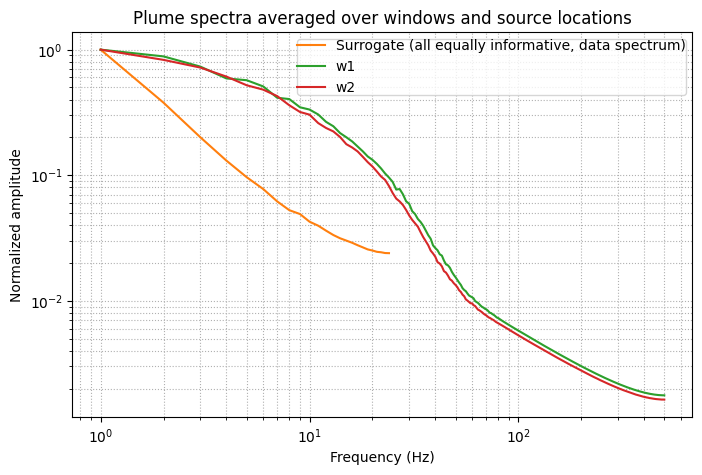

In [179]:
figure(figsize=(8,5))
for k, F in sorted(data.items()):
    f = []
    for _, s in F.sims.items():
        fs = F.fs.to(UNITS.hertz).magnitude
        fr, ti, S = stft(s.data[:,iprb], fs = fs, window='boxcar',
                         nperseg=int(fs), noverlap=fs//2, boundary=None, padded=False)
        f.append(np.abs(S))
        
    f = np.array(f)
    a = np.mean(f,axis=-1).mean(axis=0)    
    loglog(fr[fr<fs/2][1:],a[fr<fs/2][1:]/a[1],
           label=infos[k].name,
           color=infos[k].color)
legend(borderpad=0)
xlabel("Frequency (Hz)")
ylabel("Normalized amplitude")
title("Plume spectra averaged over windows and source locations")
grid(True, which='both', linestyle=":")
file_name = f"figs/wnd_1sec_boxcar/spectra.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

### Set the desired window size(s) for the analysis

In [147]:
wnd_sec_vals = defaultdict(lambda: [1 * UNITS.s],
                           {"su":[1 * UNITS.s],# 2 * UNITS.s,],# 4 * UNITS.s, 5 * UNITS.s, 10 * UNITS.s],
                            "su_white":[1 * UNITS.s, 2 * UNITS.s, 4 * UNITS.s, 5 * UNITS.s, 10 * UNITS.s],
                            "su_high_pink":[ 1 * UNITS.s, 2 * UNITS.s, 4 * UNITS.s, 5*UNITS.s, 8 * UNITS.s, 10 * UNITS.s],
                            "bw":[1 * UNITS.s, 2 * UNITS.s, 4 * UNITS.s, 5 * UNITS.s,  10 * UNITS.s],                           
                            "cr":[1 * UNITS.s],# 2 * UNITS.s],#, 4 * UNITS.s, 10 * UNITS.s],
                           })

wnd_shapes = defaultdict(lambda: [('boxcar'), ('hann')],
                         {"su":[('boxcar'), ('hann'),],#('kaiser', 9), ('kaiser', 16)],
                          "su_white":[('boxcar'), ('hann')],
                          "su_high_pink": [('boxcar'), ('hann')],
                          "cr":[('boxcar'), ('hann')],# ('kaiser', 9)],
                          "bw":[('boxcar'), ('hann'), ('kaiser', 9), ('kaiser', 16)],
                          })

### Compute the metrics for the specified window sizes

In [148]:
reload(fpt)
reload(fpf)

<module 'fisher_plumes_figs' from '/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py'>

In [149]:
recompute    = []#["bw","su","su_white"]
recompute_ds = lambda ds: (recompute == True) or (type(recompute)==list and ds in recompute)

if recompute == True or ('proc' not in locals()): proc = {}

for k, F in data.items():
    istart = 0 if k[:2] in ["bw", "su"] else 1000
    if k not in proc:
        proc[k] = {}
    for iwnd, wnd_sec in enumerate(wnd_sec_vals[k]):        
        wnd = int(F.fs*wnd_sec)
        for iwnd_shape, wnd_shape in enumerate(wnd_shapes[k]):
            txt = f"Running {k} for {wnd_sec=:}, {wnd=:} {wnd_shape=:}"
            print(f"{txt:<70}", end = "")
            sys.stdout.flush()

            wnd_key = (wnd_sec, wnd_shape)
            
            if (wnd_key in proc[k]) and not recompute_ds(k):
                print(f"  Data for {wnd_key=:} already present.")
                continue
    
            # We've run for a previous window,
            # copy the object to run again with a
            # different window.
            if iwnd or iwnd_shape: F = deepcopy(F)
    
            F.compute_all_for_window(wnd      = wnd,
                                     window   = wnd_shape,
                                     istart   = istart,
                                     dmax_um  = np.inf,
                                     fit_vars = False,
                                     fit_k    = False,
            )
            
            proc[k][wnd_key] = F

Running w1 for wnd_sec=1 s, wnd=1000 wnd_shape=boxcar                 

  Data for wnd_key=(<Quantity(1, 'second')>, 'boxcar') already present.
Running w1 for wnd_sec=1 s, wnd=1000 wnd_shape=hann                   

  Data for wnd_key=(<Quantity(1, 'second')>, 'hann') already present.
Running su for wnd_sec=1 s, wnd=50 wnd_shape=boxcar                   

  Data for wnd_key=(<Quantity(1, 'second')>, 'boxcar') already present.
Running su for wnd_sec=1 s, wnd=50 wnd_shape=hann                     

  Data for wnd_key=(<Quantity(1, 'second')>, 'hann') already present.
Running w2 for wnd_sec=1 s, wnd=1000 wnd_shape=boxcar                 

           fisher_plumes 2023/06/12 15:53:07     INFO: STARTING COMPUTATION.


           fisher_plumes 2023/06/12 15:53:07     INFO: Window set to self.wnd=1000.


           fisher_plumes 2023/06/12 15:53:07     INFO: Computing trig coefficients for crimgrid_first_slow_w2 with istart=1000 and window='boxcar' and z_score=True and kwargs={} 


           fisher_plumes 2023/06/12 15:53:07     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/06/12 15:53:08     INFO: Computing variances for harmonics.


           fisher_plumes 2023/06/12 15:53:08     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/06/12 15:53:15     INFO: Computing lambdas.


           fisher_plumes 2023/06/12 15:53:15    DEBUG: sum(freqs<=fmax)=501.


           fisher_plumes 2023/06/12 15:53:16    DEBUG: data.shape=(51, 2, 3072)


           fisher_plumes 2023/06/12 15:53:16    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/06/12 15:54:09    DEBUG: utils.d1(self.la[0]).shape=(51, 501)


           fisher_plumes 2023/06/12 15:54:09     INFO: Computing p-values.


           fisher_plumes 2023/06/12 15:54:09     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/06/12 15:54:13     INFO: Computing R^2-values.


           fisher_plumes 2023/06/12 15:54:13     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/06/12 15:54:15     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/06/12 15:54:15     INFO: Using 35 distances <= inf um 


           fisher_plumes 2023/06/12 15:54:15     INFO: Computed λ for 501 frequencies and 35 distances and 51 bootstraps.


           fisher_plumes 2023/06/12 15:54:15     INFO: Not fitting k by using bounds_dict['k']=(1, 1.000001)


           fisher_plumes 2023/06/12 15:54:15     INFO: Not fitting amplitudes, instead using given values.


     fisher_plumes_tools 2023/06/12 15:54:15    DEBUG: DUMP_IF_FAIL caught an exception.


     fisher_plumes_tools 2023/06/12 15:54:15    DEBUG: Wrote args and kwargs to dumpiffail.p.


ValueError: array must not contain infs or NaNs

### Set the time window of data that we want to plot

In [71]:
proc.keys()

dict_keys(['su', 'w1'])

In [72]:
wnd2str = lambda wnd_t,wnd_sh: "_".join([
    f"wnd_{wnd_t.to(UNITS.s).magnitude:g}sec", f"{wnd_sh[0] if type(wnd_sh) is tuple else wnd_sh}"] + ([str(wnd_sh[1])] if type(wnd_sh) is tuple else []))
wnd_sec = 1 * UNITS.sec
wnd_shp = ('hann') #('kaiser', 9)
wnd_key = (wnd_sec, wnd_shp)
data_wnd = {k:v[wnd_key] for k,v in proc.items() if wnd_key in v and k != "su_high_pink"}
wnd_str = wnd2str(*wnd_key)
print(f"{len(data_wnd)} processed datasets found for {wnd_key=}\n{wnd_str=}")
print(list(data_wnd.keys()))

2 processed datasets found for wnd_key=(<Quantity(1, 'second')>, 'hann')
wnd_str='wnd_1sec_hann'
['su', 'w1']


### Whether to save the plots we make and where to put them

In [73]:
SAVEPLOTS = False # Whether to actually make the plots
fig_dir_fun = lambda wnd_str: f"figs/{wnd_str}"
fig_dir = fig_dir_fun(wnd_str)
if not os.path.exists(fig_dir):
    print(f"Creating {fig_dir=}")
    os.mkdir(fig_dir)
else:
    print(f"{fig_dir=} already exists.")

fig_dir='figs/wnd_1sec_hann' already exists.


# Figure showing an example plume and correlations

In [83]:
DEFAULT   = "default"
isdefault = lambda x: type(x) is str and x == DEFAULT

su_ds = [k for k in data if k.startswith("su")]
print(f"Surrogate datasets = {su_ds}.")

which_srcs   = dict_update_from_field({"bw":[-3750, 3750],        "cr":[490000,510000],       "w1":[107300, 114700]},       su_ds, "bw")        
t_wnd        = dict_update_from_field({"bw":[-4,4]*UNITS.sec,     "cr":[-0.5, 0.5]*UNITS.sec}, su_ds + ["w1"], "bw")
which_idists = dict_update_from_field({"bw":[0,2,3],              "cr":[0,10,20]},             su_ds + ["w1"], "bw")
tticks       = dict_update_from_field({"bw":DEFAULT,              "cr":[39.5,40,40.5]},        su_ds + ["w1"], "bw")
xticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds + ["w1"], "bw")
yticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds + ["w1"], "bw")

Surrogate datasets = ['su'].


[99900, 114700, 107300, 62900, 122100, 151700, 144300, 166500, 159100, 92500, 129500, 77700, 136900, 55500, 70300, 85100]


      fisher_plumes_figs 2023/06/12 15:41:02     INFO: Clipped snapshots to limsx=array([  51, 1059]), limsy=array([ 33, 404]).


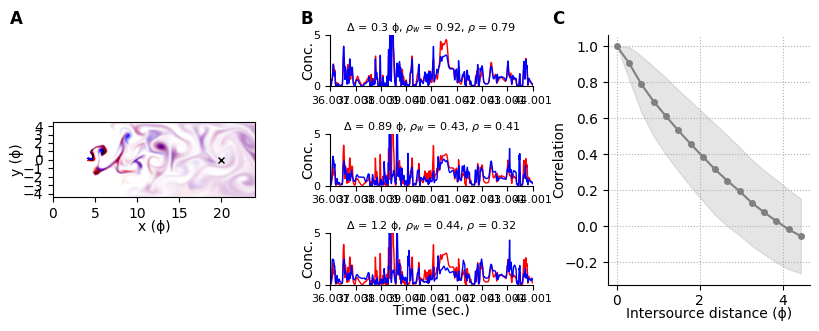

<AxesSubplot: xlabel='x (ϕ)', ylabel='y (ϕ)'>

In [137]:
reload(fpf)
reload(fpft)

for k, F in sorted(data_wnd.items()):
    if k.startswith("su"): continue
#    data_dir = os.path.join(os.environ["FISHER_PLUMES_DATA"], defaultdict(str, {"bw":"boulder", "cr":"crick"})[k], "saved-snapshots")
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, 40001 * UNITS.ms, which_srcs[k],
                                                    y_lim = (0,5.01) if k[:2]!="su" else (-3.01,3.01), y_ticks = [-3,0,3] if k[:2]=="su" else None,
                                                    t_wnd = t_wnd[k], dt = 1 * UNITS.sec, which_idists=which_idists[k])
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])
    if k in ["su_high", "su", "bw"]: ax_corr.set_xticks(arange(5))
    if k.startswith("su"): [ax_corr.set_ylim(-0.85,1.05), ax_corr.set_ylabel("Correlation",labelpad=-8)]
    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir}/plumes_demo_{k}.pdf"
    #ax_corr.set_ylim(-0.5,1.02)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()
ax_plume

In [136]:
ax_plume.get_position()

Bbox([[0.06447916666666667, 0.12111111111111106], [0.31359375000000006, 0.9533333333333335]])

In [131]:
dir(ax_plume)

['ArtistList',
 '_AxesBase__clear',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axis_map',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_deprecate_noninstance',
 '_errorevery_to_mask',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_fully_clipped_to_axes',
 '_

# Set the probe index we'll use

In [21]:
iprb = 0

# Figure showing the distribution of correlations

cr
Mapped frequencies [ 1  2  3 17 20] Hz to indices [1, 2, 3, 17, 20].


Wrote figs/wnd_1sec_hann/corr_components_cr.pdf.


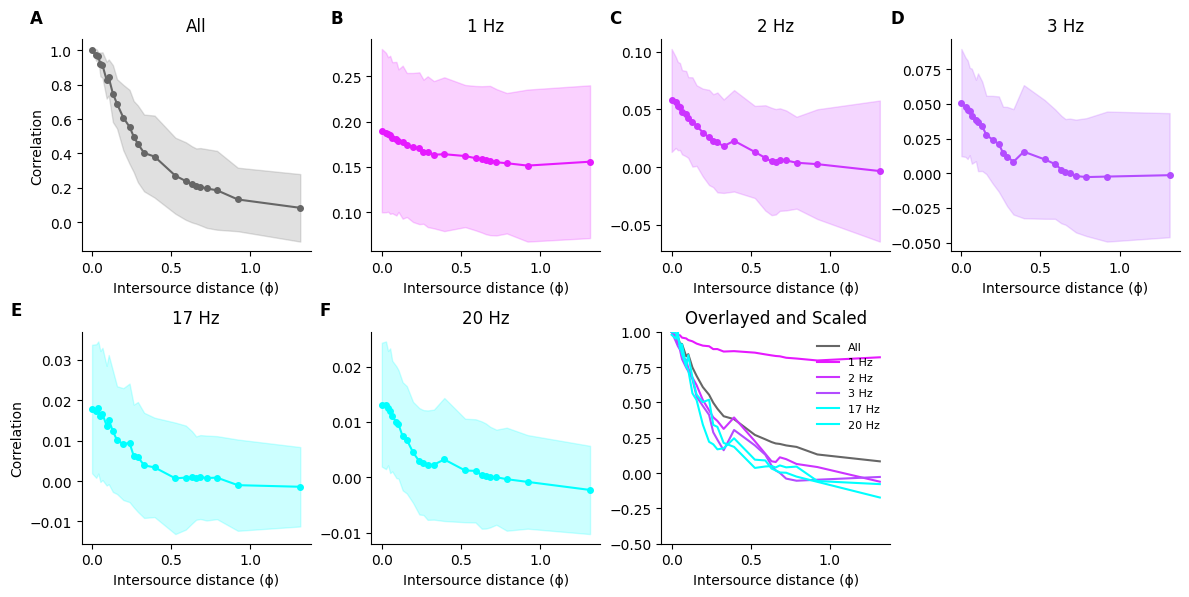

In [39]:
reload(fpf)
xlims_  = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
xticks_ = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
for k, F in data_wnd.items():
    which_freqs = ([1,2,3,17,20] if k.startswith("su_high") else [1,2,3,17,20]) * UNITS.Hz
    labs = [f"{f}" for f in which_freqs]
    cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/10) for f in which_freqs])})    
    print(k)
    slices = {"All":slice(1,10000)}
    freq_inds = F.freqs2inds(which_freqs)
    print(f"Mapped frequencies {which_freqs} to indices {freq_inds}.")
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})
    ax = fpf.plot_correlations(F.rho[iprb], F.pitch.to("um").magnitude, slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel(f"Intersource distance ({fpf.pitch_sym})"),
      not isdefault(xlims_[k])  and axi.set_xlim(xlims_[k]),
      not isdefault(xticks_[k]) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)
    ax[-1].set_ylim(-0.5,1)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."))
    sys.stdout.flush(); plt.show()

# The Multivariate Gaussian Fits

cr
Mapped 5 Hz to index 5.


Wrote figs/wnd_1sec_hann/coef_vs_coef_cr_5Hz.pdf.


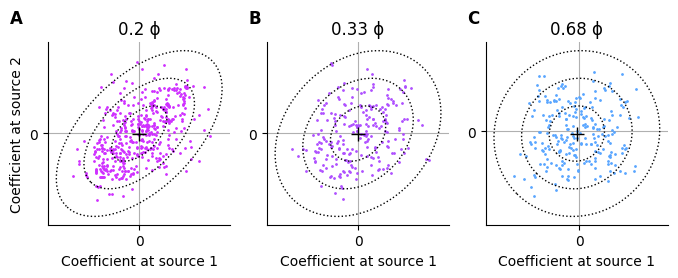

In [40]:
reload(fpf)
which_freqs = dict_update_from_field({"bw":5 * UNITS.hertz, "cr":5 * UNITS.hertz}, su_ds, "bw")
which_idists= dict_update_from_field({"bw":[0,2,4],         "cr":[8,12,18]},       su_ds, "bw")
dcol_scales = dict_update_from_field({"bw":120000,          "cr":80000},           su_ds, "bw")
for name, F in sorted(data_wnd.items()):
    print(name)
    which_freq = which_freqs[name]
    ifreq = F.freqs2inds([which_freq])[0]
    print(f"Mapped {which_freq} to index {ifreq}.")
    ax = fpf.plot_coef1_vs_coef2([F.ss[iprb], F.cc[iprb]],
                                 ifreq,
                                 F.pairs_um,
                                 F.pitch_string,                                 
                            i_pos_dists_to_plot = which_idists[name],
                            dist_col_scale = dcol_scales[name]
    )
    fpft.label_axes(ax, "ABC", fontsize=12, fontweight="bold", dy=-0.01)            
    file_name = f"{fig_dir}/coef_vs_coef_{name}_{which_freq.magnitude}Hz.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Supplementary Information

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Wrote figs/wnd_1sec_hann/coefs_and_traces_cr_5Hz.pdf.


<Figure size 800x300 with 0 Axes>

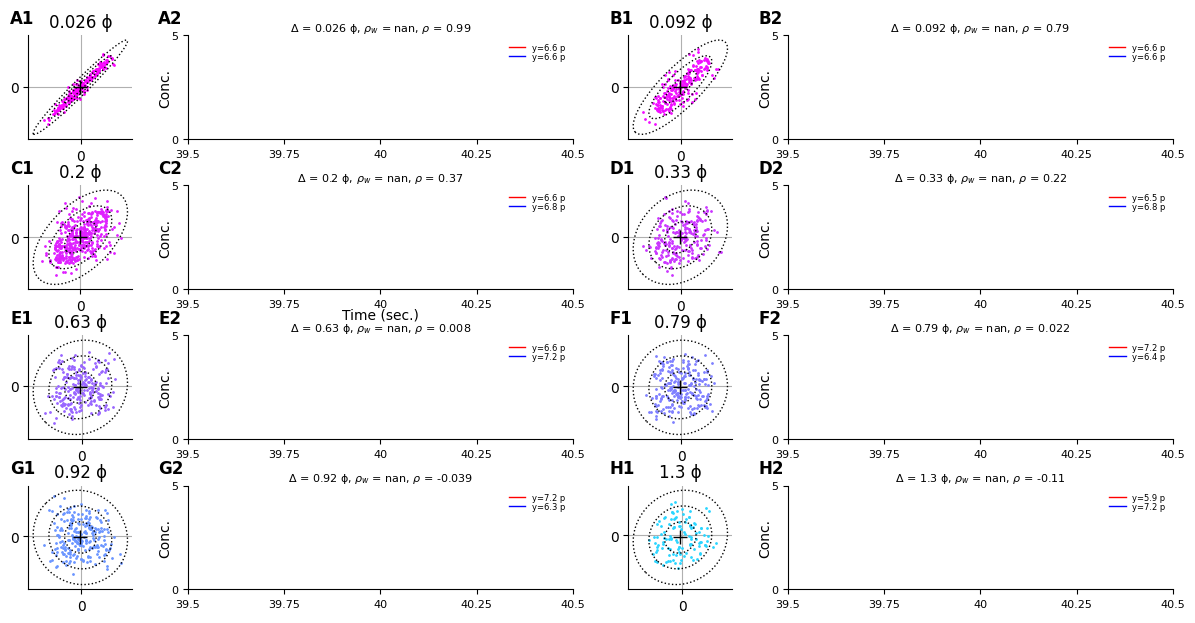

In [24]:
reload(fpf)
reload(fpft)
freq      = dict_update_from_field({"bw":5 * UNITS.hertz,          "cr":5 * UNITS.hertz},        su_ds, "bw")
idists    = dict_update_from_field({"bw":[0,1,2,3,4,6,7,12],       "cr":[0,4,8,12,16,20,21,22]}, su_ds, "bw")
t_lim     = dict_update_from_field({"bw":[35, 45]*UNITS.sec,       "cr":[39.5,40.5]*UNITS.sec},  su_ds, "bw")
dt        = dict_update_from_field({"bw":1*UNITS.sec,              "cr":0.25*UNITS.sec},         su_ds, "bw")
for k, F in sorted(data_wnd.items()):
    figure(figsize=(12,6))
    coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k],
                                                         which_probe = iprb, n_per_row = 2,
                                                         y_lim=[0,5] if k[:2]!="su" else [-3,3],
                                                         t_lim = t_lim[k],
                                                         dt = dt[k])
    for ax in coef_ax:
        ax.set_xlabel("")
        ax.set_ylabel("")
    [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
    tight_layout(pad=0)
    all_ax = bsum([[ax_c, ax_t] for ax_c, ax_t in zip(coef_ax, trace_ax)], [])
    n_ax   = len(all_ax)
    fpft.label_axes(all_ax,
                    [ch+nu for ch in "ABCDEFGH" for nu in "12"],
                    align_x = [list(range(i,n_ax,4)) for i in range(4)],
                    align_y = [list(range(i,i+4)) for i in range(0,n_ax,4)],
                    fontsize=12, fontweight="bold", dy=-0.01)
    file_name = f"{fig_dir}/coefs_and_traces_{k}_{freq[k].to(UNITS.hertz).magnitude}Hz.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Asymmetric Laplacian Fits

      fisher_plumes_figs 2023/05/30 21:37:10     INFO: d=2000 @ Freq #   1: -np.log10(p) = 22.976


      fisher_plumes_figs 2023/05/30 21:37:10     INFO: d=25000 @ Freq #   1: -np.log10(p) = 23.524


      fisher_plumes_figs 2023/05/30 21:37:10     INFO: d=52000 @ Freq #   1: -np.log10(p) = 19.680


cr
Setting extent to [-0.5, 23.5, 0.5, 100.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec_hann/alap_fits_cr_1Hz.pdf.


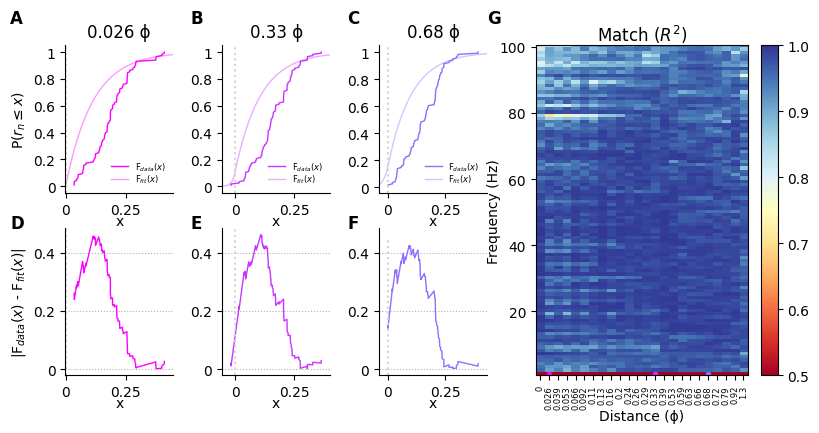

      fisher_plumes_figs 2023/05/30 21:37:12     INFO: d=2000 @ Freq #   5: -np.log10(p) = 1.803


      fisher_plumes_figs 2023/05/30 21:37:12     INFO: d=25000 @ Freq #   5: -np.log10(p) = 0.773


      fisher_plumes_figs 2023/05/30 21:37:12     INFO: d=52000 @ Freq #   5: -np.log10(p) = 1.026


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 23.5, 0.5, 100.5].


Wrote figs/wnd_1sec_hann/alap_fits_cr_5Hz.pdf.


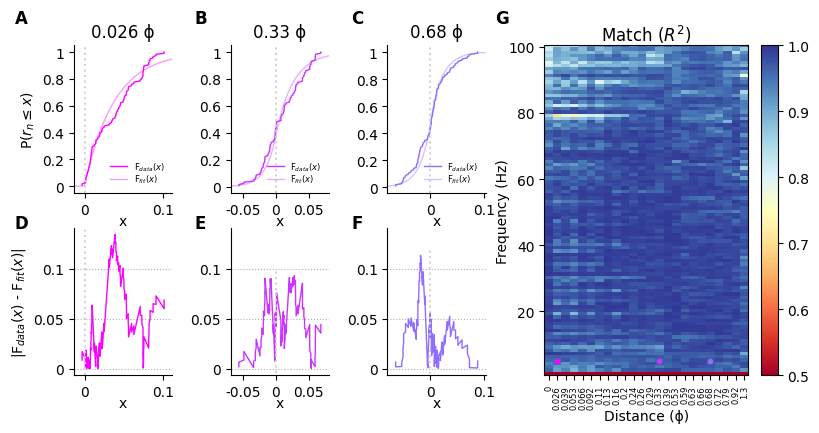

      fisher_plumes_figs 2023/05/30 21:37:13     INFO: d=2000 @ Freq #  10: -np.log10(p) = 0.895


      fisher_plumes_figs 2023/05/30 21:37:13     INFO: d=25000 @ Freq #  10: -np.log10(p) = 1.896


      fisher_plumes_figs 2023/05/30 21:37:13     INFO: d=52000 @ Freq #  10: -np.log10(p) = 0.053


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 23.5, 0.5, 100.5].


Wrote figs/wnd_1sec_hann/alap_fits_cr_10Hz.pdf.


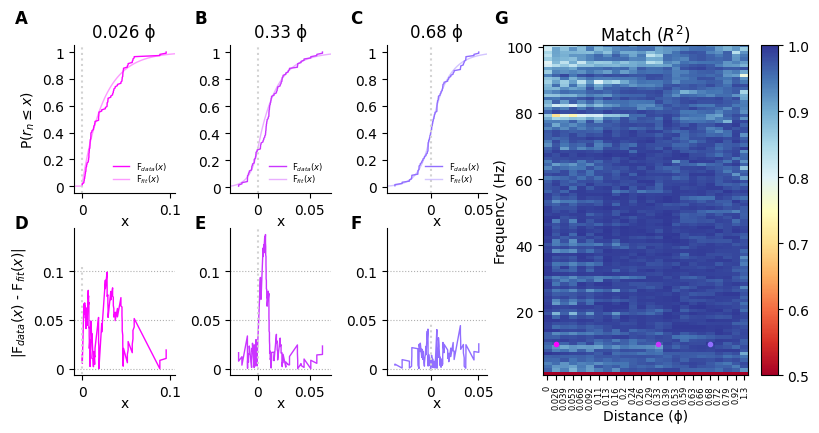

In [25]:
reload(fpft)
reload(fpf)
which_wnd_sec = wnd_sec_vals[0]
idist     = dict_update_from_field({"bw":[1,2,3],          "cr":[1,13,19]},         su_ds, "bw")
freq_max  = dict_update_from_field({"bw":21 * UNITS.hertz, "cr":101 * UNITS.hertz}, su_ds, "bw")
vmin      = dict_update_from_field({"bw":[0,0.0],          "cr":[0,0.5]},           su_ds, "bw")
vmax      = dict_update_from_field({"bw":[50,1],           "cr":[10,1]},            su_ds, "bw")
plot_pvals= False
for name, F in sorted(data_wnd.items()):
    if name == "bw1": continue
    print(name)
    d = np.array(list(F.rho[iprb].keys()))
    d = np.sort(d[d>=0])
    for f in [1, 5, 10] * UNITS.hertz:
        which_freq = defaultdict(lambda: f)
        ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                                                        which_probe = iprb,
                               ifreq_lim = [1, F.freqs2inds([freq_max[name]])[0]],
                               which_ifreq = F.freqs2inds([which_freq[name]])[0],
                                                        figsize=(8,4),
                                                        vmax=vmax[name],
                                                        vmin=vmin[name],
                                                        plot_dvals=True,
                                                        plot_pvals=plot_pvals)
        tight_layout(pad=0)
        fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                        align_y = [[0,1,2,6],[3,4,5,7]] if plot_pvals else [[0,1,2],[3,4,5]],
                        align_x = [[0,3],[1,4],[2,5]],
                        fontsize=12, fontweight="bold", dy=0)
        file_name = f"{fig_dir}/alap_fits_{name}_{which_freq[name].to(UNITS.hertz).magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

# Plot the figure showing λ(s)

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)
      fisher_plumes_figs 2023/05/30 21:37:17     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 17, 19], log_scale=True.


wnd_key=(<Quantity(1, 'second')>, 'hann')
cr


Wrote figs/wnd_1sec_hann/la_vs_s_fits_cr.pdf.


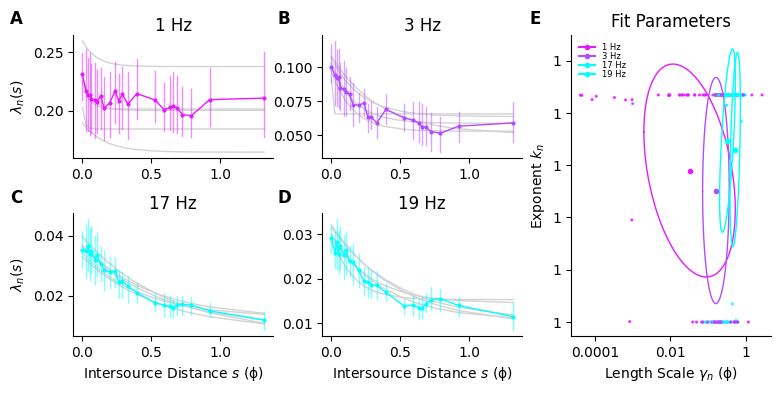

In [26]:
reload(fpft)
reload(fpf)
freqs  = dict_update({fld:[1,3,17,19] * UNITS.hertz for fld in ["bw", "cr", "su"]}, ["su_high_white", "su_high_pink", "su_high2_pink", "su_white"], [[1,3,17,20] * UNITS.hertz]*4)
xl     = dict_update_from_field({"bw":(-10,200),                 "cr": (-2, 50)},                    su_ds, "bw")
xt     = dict_update_from_field({"bw":arange(0,201,50),          "cr": arange(0,101,25)},            su_ds, "bw")
xtp    = dict_update_from_field({"bw":np.array([60,90,135]),     "cr": np.array([40,60, 90, 135])},  su_ds, "bw")
ytp    = dict_update_from_field({"bw":np.array([0.8,1,1.2,1.5]), "cr": np.array([0.8,1,1.2,1.5,2])}, su_ds, "bw")

print(f"{wnd_key=:}")
data_wnd = {k:v[wnd_key] for k,v in proc.items() if wnd_key in v and k != "su_high_pink"}
for k, F in sorted(data_wnd.items()):
    print(k)
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          which_ifreqs = F.freqs2inds(freqs[k]))
    [((i>1) and axi.set_xlabel(f"Intersource Distance $s$ ({fpf.pitch_sym})")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"{fig_dir}/la_vs_s_fits_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Plot the Fisher Information

      fisher_plumes_figs 2023/05/30 21:37:27     INFO: dd[0]=100, dd[-1]=125000 (0.00131579, 1.64474 ϕ)


cr


      fisher_plumes_figs 2023/05/30 21:37:28     INFO: Plotting which_ifreqs=[5, 10, 20, 50, 100].


Wrote figs/wnd_1sec_hann/fisher_info_cr.pdf.


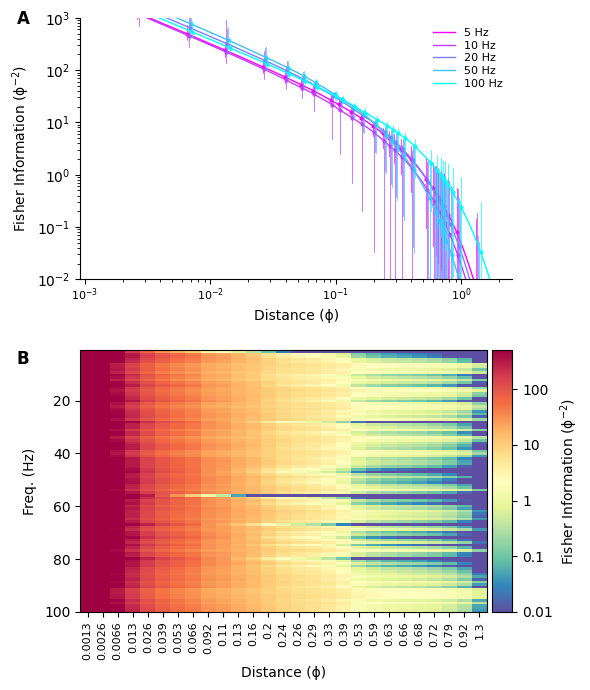

In [27]:
reload(fpt)
reload(fpft)
reload(fpf)
freqs     = dict_update_from_field({"cr":[5,10,20,50,100] * UNITS.hertz, "bw":[1,2, 5, 10, 20] * UNITS.hertz}, su_ds, "bw")
freq_max  = dict_update_from_field({"bw":25 * UNITS.hertz, "cr":100 * UNITS.hertz}, su_ds, "bw")
colscale  = dict_update_from_field({"bw":10,               "cr":40},                su_ds, "bw")
d_vals_um = dict_update_from_field({"bw":[1,5,50],         "cr":[0.1,10,70]},       su_ds, "bw")
d_lim_um  = dict_update_from_field({"bw":[100, 125000 ],   "cr":[100, 125000]},     su_ds, "bw")
bf_ytick  = dict_update_from_field({"bw":[0,5,10],         "cr":[0,50,100]},        su_ds, "bw")
bf_yl     = dict_update_from_field({"bw":[0,15],           "cr":[-5,100]},          su_ds, "bw")
plot_param_fits = False
for k, F in sorted(data_wnd.items()):
    print(k)
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,
                                                                which_probe = iprb,
                                                                d_lim_um   = d_lim_um[k],
                                                                d_vals_um  = np.array(d_vals_um[k])*1000,
                                                                d_space_fun  = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                                                which_ifreqs = F.freqs2inds(freqs[k]),
                                                                x_stagger = lambda x, i: x*(1.02**i),
                                                                plot_fun = plt.loglog,
                                                                log_scale = True,
                                                                plot_param_fits = plot_param_fits,
                                                                freq_max  = freq_max[k],
                                                                colfun    = lambda f: cm.cool_r(f/colscale[k]),
                                                                info_heatmap = True,
                                                                heatmap_range =[-2, log10(500)],
                                                                heatmap_cm    =cm.Spectral_r,
                                                                #bf_ytick  = bf_ytick[k],
    )
    ax_fisher.set_ylim(1e-2,1e3)
    tight_layout(h_pad=2,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    #align_y = [[2,3,4]],
                    align_x = [[0,1,2] if plot_param_fits else [0,1]],
                    fontsize=12, fontweight="bold", dy=-0.02)
    #ax_best_freq.set_ylim(bf_yl[k])
    file_name = f"{fig_dir}/fisher_info_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()
    

# Plot Fisher information heatmaps together

KeyError: 'bw'

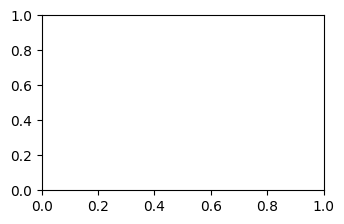

KeyError: 'bw'

In [28]:
figure(figsize=(8,5))
gs = GridSpec(2,2)
order = ["bw", "su", "su_high_white", "su_high_pink"]
which_wnd = (1 * UNITS.s, 'boxcar')
axes, cbs = [], []
for o, gsi in zip(order, gs):
    axes.append(subplot(gsi))
    axes[-1], cbi = fpf.plot_fisher_information_heatmap(proc[o][which_wnd], 0, ax = axes[-1], freq_max = freq_max[o],
                                                        heatmap_range =[-2, log10(500)],
                                                        heatmap_cm    =cm.Spectral_r,
                                                        do_colorbar   = gsi.is_last_col(),
    )
    if gsi.is_first_row():
        axes[-1].tick_params(labelbottom=False)
        axes[-1].set_xlabel("")

    if not gsi.is_first_col():
        axes[-1].tick_params(labelleft = False)
        axes[-1].set_ylabel("")
tight_layout(w_pad = 1.5, h_pad=1.5)
fpft.label_axes(axes, "ABCD",
                align_y = [[0,1],[2,3]],
                align_x = [[0,2],[1,3]],
                fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
file_name = f"figs/fisher_info_heatmaps.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()
        

# Main figure showing effect of windowing

KeyError: 'su'

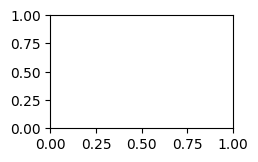

KeyError: 'su'

In [29]:
reload(fpf)
figure(figsize=(8,5))
col_keys = [(10 * UNITS.s, 'boxcar'), (1 * UNITS.s, 'hann'), (5 * UNITS.s, 'hann')]
heatmap_range = defaultdict(lambda: [-2, log10(500)], {"bw":[-2,log10(500)], "su_high2_pink":[-2,log10(500)]})
row_ds   = ["su", "su_high_pink", "bw"]
gs       = GridSpec(len(row_ds), len(col_keys))
ax       = []
for i, ds in enumerate(row_ds):
    for j, ck in enumerate(col_keys):
        ax.append(subplot(gs[i,j]))
        p = proc[ds][ck]
        _, cb = fpf.plot_fisher_information_heatmap(
            p, 0, ax = ax[-1], heatmap_range = heatmap_range[ds],
            do_colorbar = gs[i,j].is_last_col(),
        )
        if gs[i,j].is_last_col() and i!=1: cb.ax.set_ylabel("")
        if not gs[i,j].is_first_col(): ax[-1].set_ylabel("")
        if not gs[i,j].is_last_row():  [ax[-1].set_xlabel(""),ax[-1].set_xticklabels([])]
tight_layout(w_pad = 1.5, h_pad=1.5)
fpft.label_axes(ax, "ABCDEFGHI",
                align_y = [[0,1,2],[3,4,5],[6,7,8]],
                align_x = [[0,3,6],[1,4,7],[2,5,8]],
                fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
file_name = f"figs/effect_of_windowing.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()
        


# Length constants vs frequency

In [30]:
reload(fpf)
which_ds = ["bw","su"]
names = {"su":"Surrogate data", "bw":"Simulations"}
cols = {"su":cm.gray(0.4), "bw":cm.GnBu(0.75)}
which_window = wnd_key #(1 * UNITS.s, ("kaiser",9))
gamma_plot_width = 2
gs = GridSpec(len(which_ds), 1+gamma_plot_width+1)
figure(figsize=(8,2 * len(which_ds)))
ax = []
which_corr_freqs = [2,5,10,20] * UNITS.Hz
labs = [f"{f}" for f in which_corr_freqs]
cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/20) for f in which_corr_freqs])})
freq_min = (1/which_window[0].to(UNITS.s).magnitude) * UNITS.Hz
coef_γ_vs_freq = {}
for i, ds in enumerate(which_ds):
    F = proc[ds][which_window]
    coef_γ_vs_freq[ds] = F.coef_γ_vs_freq[iprb]
    d_scale = F.pitch.to(UNITS.um).magnitude
    freq_inds = F.freqs2inds(which_corr_freqs)
    slices = {}    
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})    
    ax.append(subplot(gs[i,0]))
    fpf.plot_correlations(F.rho[0], F.pitch.to(UNITS.um).magnitude, slices = slices, cols = cols,
                          plot_slices = False, plot_overlay=True, ax = [ax[-1]],
                          legend_args = {"handlelength":1.25, "handletextpad":0.5, "borderpad":0},
                          
                          
    )
    ax[-1].set_xlabel(f"Intersource distance ({fpf.pitch_sym})")
    ax[-1].set_title("")
    ax[-1].set_yticks(np.arange(0,1.1,0.5))
    ax[-1].set_ylabel("Correlations")
    ax.append(subplot(gs[i,1:1+gamma_plot_width], sharey=None if not i else ax[1]))
    γbs = F.fit_params[0][1:][:,:,1]
    freq_max = F.freq_max
    freqs_γ  = F.freqs[:γbs.shape[1]]
    ind_use  = (freqs_γ > freq_min) & (freqs_γ <= freq_max)
    lo,md,hi = percentile(γbs, [5,50,95], axis = 0) / d_scale
    
    ax[-1].plot(freqs_γ[ind_use].to(UNITS.Hz).magnitude, md[ind_use], "o",color=cols[ds], markersize=4)
    ax[-1].plot([freqs_γ[ind_use].to(UNITS.Hz).magnitude]*2, [lo[ind_use], hi[ind_use]], color=cols[ds],linewidth=1)
    ax[-1].set_xlabel("Frequency (Hz)")
    ax[-1].set_ylabel(f"Length constant ({fpf.pitch_sym})")
    fpft.spines_off(ax[-1])

ax_γ = subplot(gs[:,-1])
box = ax_γ.boxplot(vstack([coef_γ_vs_freq[ds][:,-1] for ds in which_ds]).T, patch_artist=True,
                   widths=0.25, labels = [{"su":"Surrogate","bw":"Sims"}[dsi] for dsi in which_ds],
                   whis = [5,95],
                   
)
ax_γ.set_ylabel("$\Delta \gamma / \Delta f$", fontsize=11,labelpad=-1)
[setp(b, color = fpft.set_alpha(cols[ds],0.5), facecolor=fpft.set_alpha(cols[ds],0.5)) for ds, b in zip(which_ds, box["boxes"])]
[setp(b, color = cols[ds], linewidth=1) for ds, b in zip(which_ds, box["medians"])]
fpft.spines_off(ax_γ)
tight_layout(w_pad=0)

fpft.label_axes(ax + [ax_γ], "ABCDE",
                fontsize=12, fontweight="bold",
                dx = -0.01, dy=0.01,
                align_x = [[0,2],[1,3]],
                align_y = [[0,1,4]])

file_name = f"{fig_dir}/length_vs_freq.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()

KeyError: 'bw'

<Figure size 800x400 with 0 Axes>

KeyError: 'bw'

# Regressing information on frequency

In [31]:
which_ds = ["bw","su"]
names = {"su":"Surrogate data", "bw":"Simulations"}
cols = {"su":cm.gray(0.4), "bw":cm.GnBu(0.75)}
which_window = wnd_key
which_log10_dists = defaultdict(lambda: [-1,0, log10(2)])
mean_normalize = True
same_plot = True
coef_plot_width = 2
gs = GridSpec(len(which_ds), len(which_log10_dists[which_ds[0]])+coef_plot_width)
figure(figsize=(8,2.5 * len(which_ds)))
ax = []
for i, ds in enumerate(which_ds):
    ax.append([])
    F = proc[ds][which_window]
    I = F.I[iprb][0]
    I_freqs = F.freqs[:I.shape[0]]
    ind_use = (I_freqs >= F.reg_freq_range[0]) & (I_freqs <= F.reg_freq_range[1])
    xx = I_freqs[ind_use].to(UNITS.Hz).magnitude
    xe = linspace(min(xx),max(xx),101)    
    d_scale = F.pitch.to(UNITS.um).magnitude        
    dd = F.I_dists/d_scale
    which_idists = []
    for j, ddj in enumerate(which_log10_dists[ds]):
        which_idist = argmin(abs(dd - 10**ddj))
        which_idists.append(which_idist)
        ax[i].append(subplot(gs[i,j]))
        axij = ax[i][-1]
        
        yy = I[ind_use, which_idist]
        c0,c1 = F.reg_coefs[iprb][0][which_idist]
        ye = 10**(c0 + c1 * xe)
        ym = 10**mean(log10(yy * d_scale**2))
        axij.semilogy(xx, (yy * d_scale**2)/(ym**mean_normalize),
                      "o", markersize=2,
                      label=f"FI / {ym:.2g}",
                      color = cols[ds],
        )
        axij.plot(xe, (ye * d_scale**2)/(ym**mean_normalize), "--",
                  color=cols[ds], linewidth=1,
                  label = f"$\\beta$" + f"={c1:1.1e}"
        )
        mean_normalize and axij.set_ylim(0.2,5)
        axij.legend(frameon=True, fontsize=8, labelspacing=0, handletextpad=0.5)
        xt = list(axij.get_xticks())
        if xx[0] not in xt: xt = ([xx[0]] + xt[1:]) if xt[0] < xx[0] else ([xx[0]] + xt)
        axij.set_xticks(xt)
        axij.set_xlim(0, xx[-1]+1)
        if mean_normalize:
            yt = np.array(list(arange(0.2,1,0.1)) + list(range(1,6)))
            axij.set_yticks(yt, labels= [s if s[-1] in "125" else "" for s in [f"{yti:g}" for yti in yt]], fontsize=10)
        [axij.spines[w].set_visible(False) for w in ["right", "top"]]
        not gs[i,j].is_first_col() and axij.set_yticklabels([])
        gs[i,j].is_last_row() and axij.set_xlabel("Frequency (Hz)")
        gs[i,j].is_first_col() and axij.set_ylabel("Fisher information")
        
    if same_plot and gs[i,j].is_first_row(): ax_coef = subplot(gs[:,-coef_plot_width:])
    elif not same_plot: ax_coef = subplot(gs[i,-coef_plot_width:])
    else: pass # ax_coef will already have been defined.
    pc = percentile(F.reg_coefs[iprb][1:][:,:,-1],[5,50,95],axis=0)
    ax_coef.semilogx(dd, pc[1], "o-", color=cols[ds], markersize=4, label = names[ds])
    ax_coef.fill_between(dd, pc[0], pc[2],color=fpft.set_alpha(cols[ds],0.1))
#    ax_coef.semilogx(dd[which_idists], pc[1][which_idists], "o", color = "r", markersize=4)    
    ax_coef.set_ylim(-0.05,0.05)
    ax_coef.set_ylabel("$\\beta = \Delta \log_{10}($FI$)/\Delta f$",labelpad=-8, fontsize=12)
    ax_coef.set_xlabel(f"Intersource distance ({fpf.pitch_sym})",labelpad=0, fontsize=12)
    [ax_coef.spines[w].set_visible(False) for w in ["right", "top"]]
ax_coef.grid(True, linestyle=":")
ax_coef.legend(frameon=False, labelspacing =0)
tight_layout(pad=0,w_pad=0)

for i, axi in enumerate(ax):
    for j, axij in enumerate(axi):
        trans = mtransforms.Affine2D().translate(-0.06*j,0).scale(sx=1.25,sy=1)
        bbox  = axij.get_position()
        axij.set_position(mtransforms.TransformedBbox(bbox, trans))

fpft.label_axes([ax[0][0], ax[1][0], ax_coef], "ABC",
                fontsize=12, fontweight="bold",
                align_x = [[0,1]],
                align_y = [[0,2]])

file_name = f"{fig_dir}/reg_coefs.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()

KeyError: 'bw'

<Figure size 800x500 with 0 Axes>

KeyError: 'bw'

# Information heatmaps as window size is changed

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:669: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(I[ind_use]),
/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:669: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(I[ind_use]),


Wrote figs/cr_boxcar_series.pdf.


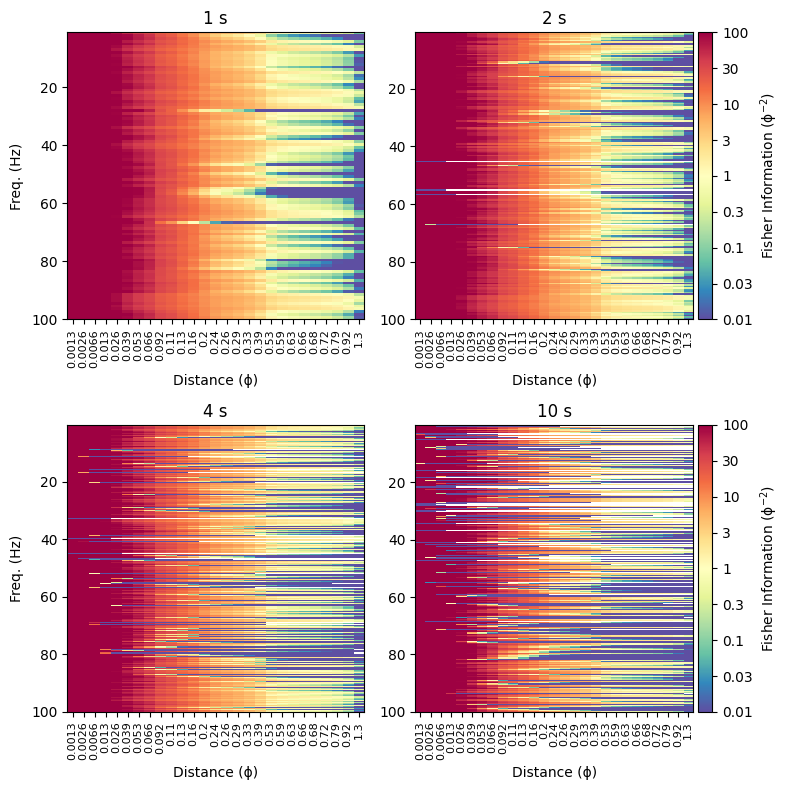

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:669: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(I[ind_use]),
/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:669: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(I[ind_use]),


Wrote figs/cr_hann_series.pdf.


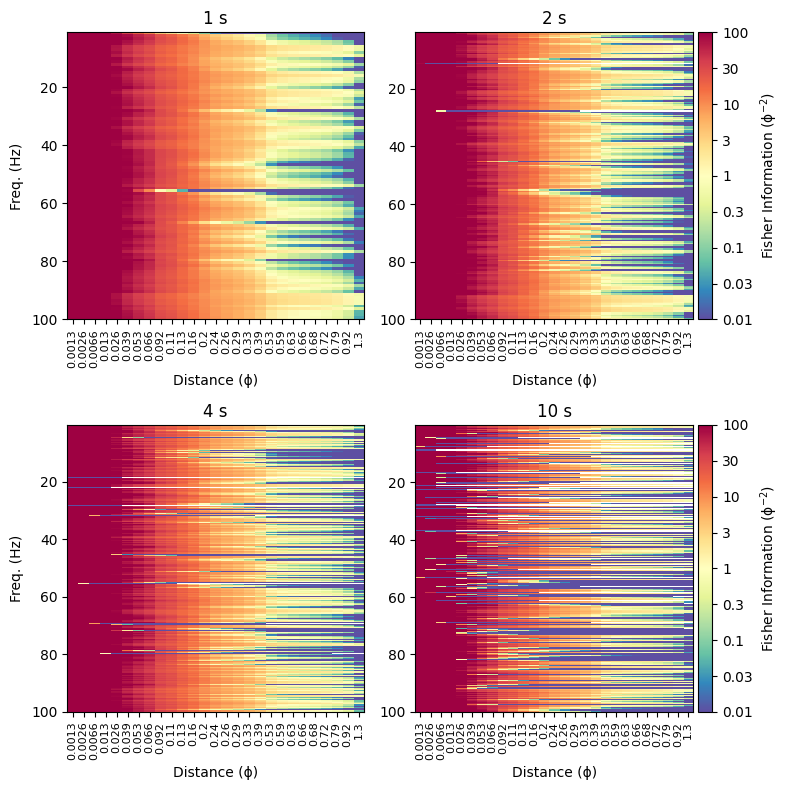

In [32]:
reload(fpf)
heatmap_range = defaultdict(lambda: [-2, log10(500)], {"cr":[-2,2], "su_high_pink":[-2,2]})
figsize       = defaultdict(lambda: (8,5), {"cr":(8,8)})
for ds, pr in proc.items():
    wnd_types = {fpt.get_window_name(f[1]) for f in pr}
    if len(wnd_types)>1:
        for wnd_type in wnd_types:
            fpf.plot_window_series(proc[ds], wnd_type, heatmap_range = heatmap_range[ds], figsize = figsize[ds])
            file_name = f"figs/{ds}_{wnd_type}_series.pdf"
            SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
            sys.stdout.flush(); plt.show()

# The End

# Sandbox

## Plot λ for random frequencies

In [33]:
1 - 20/(len(F.freqs)*20/50)

0.95

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)


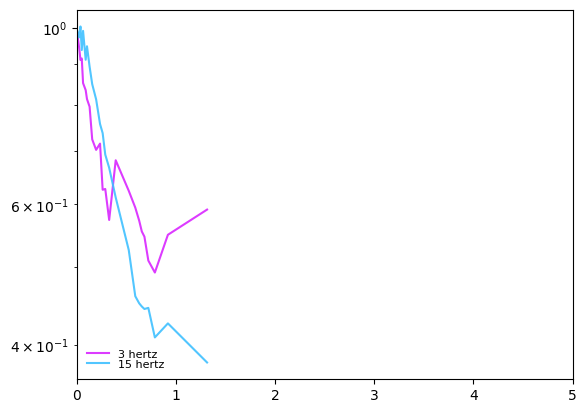

In [36]:
random.seed(1)
F = proc["cr"][(1 * UNITS.s, ('hann'))]
d = np.array(list(F.la[0].keys()))/F.pitch.to(UNITS.um).magnitude
ibs = 0
la = np.array([F.la[0][ki][ibs] for ki in F.la[0]])
la1=la/la[0]
for i, f in zip(arange(la1.shape[1]), F.freqs):
    if f == 0 * UNITS.Hz: continue
    if f>20 * UNITS.Hz: break
    if rand()> 20/(len(F.freqs)*20/50): continue
    semilogy(d, la1[:, i], color = fpft.set_alpha(cm.cool_r(f/20 * UNITS.Hz),0.9), label = f"{f:g}");
#ylim(0.2,1)
xlim(0,5)    
legend(labelspacing=0, frameon=False, loc="lower left", fontsize=8)

# # Plot window series

In [ ]:
reload(fpf)
for wnd_type in ["boxcar","hann"]:
    for ds in ["bw","su_high2_pink"]:
        fpf.plot_window_series(proc[ds], wnd_type, heatmap_cm = cm.Spectral_r, heatmap_range = [-2, log10(200)], freq_max = 20 * UNITS.Hz, n_rows = 1, figsize = (16,4))
        suptitle(f"{ds} ({wnd_type})", x=0.0, horizontalalignment="left", fontsize=8)